Ablation Study

2025-05-16 10:29:20.850778: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-16 10:29:20.850841: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-16 10:29:21.009961: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-16 10:29:21.174100: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-16 10:29:35.491952: W tensorflow/compiler/tf2

TensorFlow backend version: 2.15.0
SUCCESS: PyTorch found GPU: Quadro RTX 6000
PyTorch CUDA version: 12.6
PyTorch version: 2.7.0+cu126
Python version: 3.11.12


Running full_model
✅ Skipping full_model — already evaluated.

Running no_evt_head
✅ Skipping no_evt_head — already evaluated.

Running no_evidential_head
✅ Skipping no_evidential_head — already evaluated.

Running no_precursor_head
✅ Skipping no_precursor_head — already evaluated.

Running mean_pooling

▶ Running variant: mean_pooling
Epoch 1/300 - loss: 0.0001 - acc: 0.9929 - tss: 0.0125 - gamma: 0.00
Epoch 2/300 - loss: 0.0000 - acc: 0.9938 - tss: 0.1073 - gamma: 0.04
Epoch 3/300 - loss: 0.0000 - acc: 0.9941 - tss: 0.1524 - gamma: 0.08
Epoch 4/300 - loss: 0.0000 - acc: 0.9943 - tss: 0.1942 - gamma: 0.12
Epoch 5/300 - loss: 0.0000 - acc: 0.9946 - tss: 0.2648 - gamma: 0.16
Epoch 6/300 - loss: 0.0000 - acc: 0.9947 - tss: 0.2940 - gamma: 0.20
Epoch 7/300 - loss: 0.0000 - acc: 0.9951 - tss: 0.3583 - gamma: 0.24
Epoch 8/300 - loss

,accuracy,precision,recall,f1,roc_auc,brier,log_loss,tss
full_model,0.999526,0.791667,0.913462,0.848214,0.999915,0.001067,0.022778,0.913112
no_evt_head,0.998717,0.531915,0.961538,0.684932,0.999109,0.001136,0.010038,0.960310
no_evidential_head,0.999317,0.743363,0.807692,0.774194,0.999816,0.001022,0.009021,0.807287
no_precursor_head,0.999414,0.738462,0.923077,0.820513,0.999384,0.000718,0.006557,0.922602
focal_only_loss,0.999359,0.871795,0.653846,0.747253,0.997628,0.001081,0.011082,0.653707
no_gamma_annealing,0.999735,0.882883,0.942308,0.911628,0.999403,0.000263,0.001179,0.942126


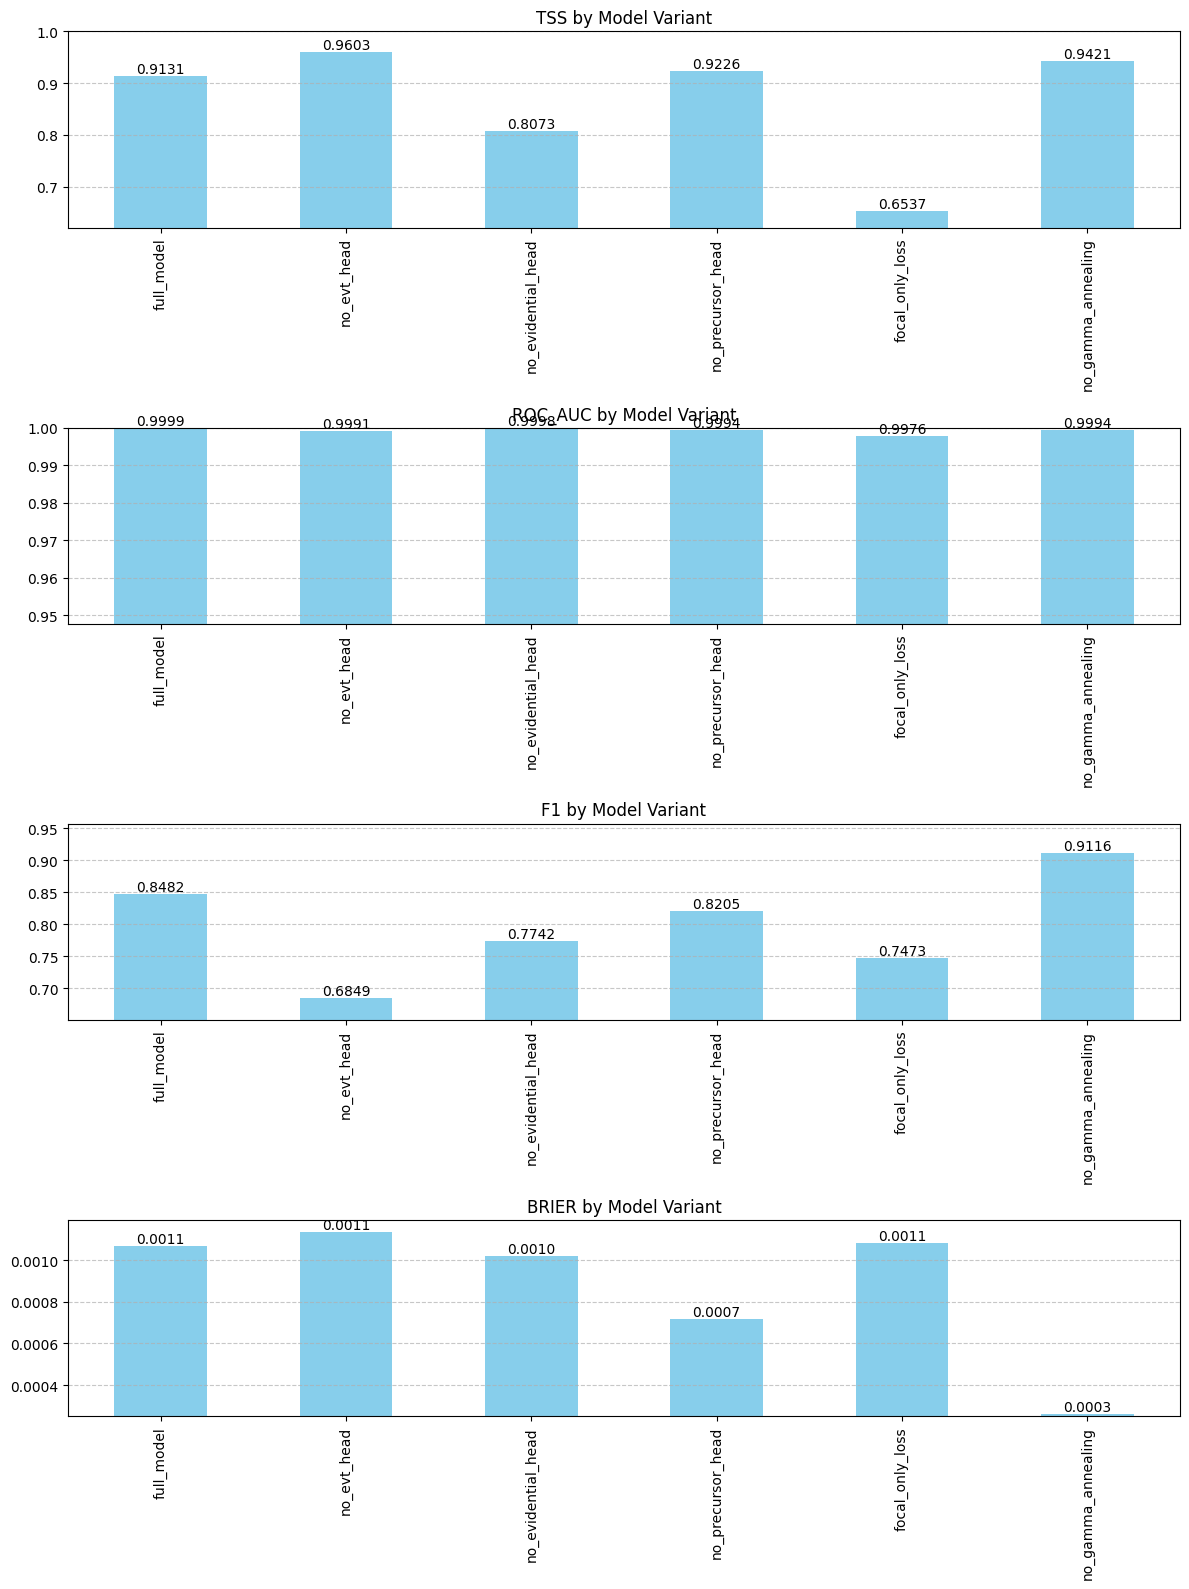

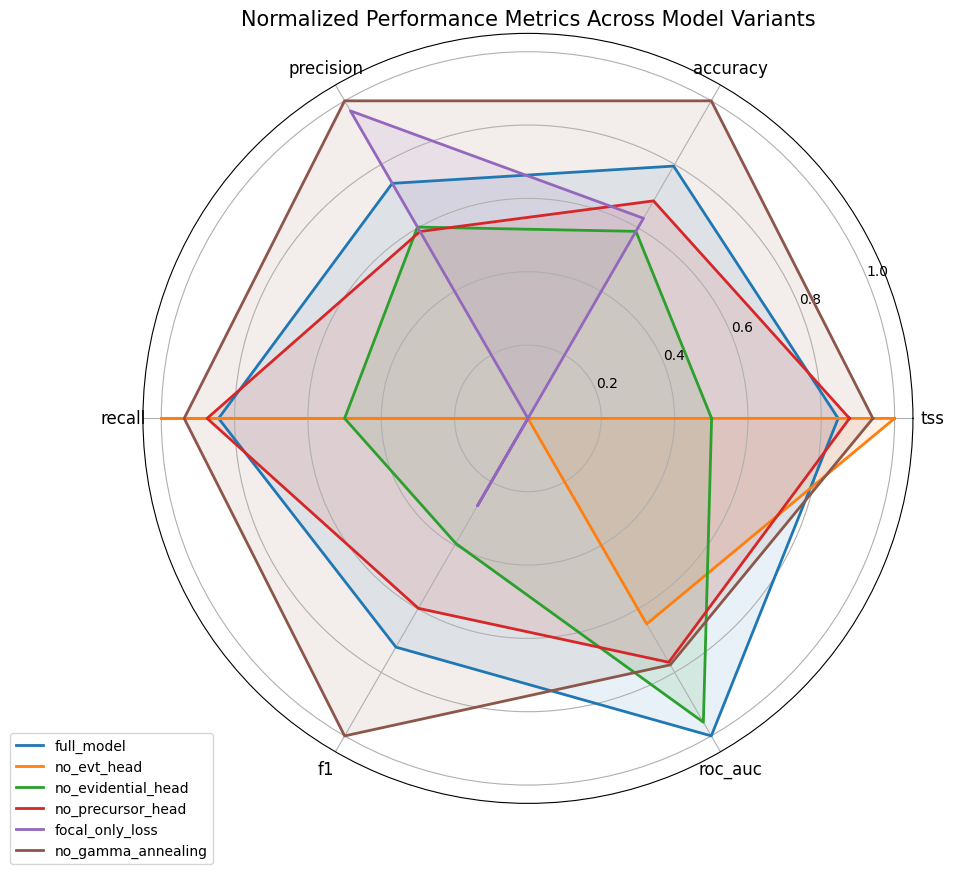

Saved summary to ablation_results_M5_72.csv


In [1]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from typing import Dict, List

import sys
sys.path.append('.')  # Add current directory to path
from solarknowledge_ret_plus import RETPlusWrapper
from utils import get_training_data, get_testing_data
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    precision_score,
    recall_score,
    roc_auc_score,
    f1_score,
    brier_score_loss,
    log_loss,
)

def evaluate_predictions(y_true: np.ndarray, y_prob: np.ndarray) -> Dict[str, float]:
    y_prob = y_prob.flatten()
    y_pred = (y_prob >= 0.5).astype(int)
    cm = confusion_matrix(y_true, y_pred)
    acc = accuracy_score(y_true, y_pred)
    tss = (cm[1, 1] / (cm[1, 1] + cm[1, 0] + 1e-8)) + (
        cm[0, 0] / (cm[0, 0] + cm[0, 1] + 1e-8)
    ) - 1
    metrics = {
        "accuracy": acc,
        "precision": precision_score(y_true, y_pred, zero_division=0),
        "recall": recall_score(y_true, y_pred, zero_division=0),
        "f1": f1_score(y_true, y_pred, zero_division=0),
        "roc_auc": roc_auc_score(y_true, y_prob),
        "brier": brier_score_loss(y_true, y_prob),
        "log_loss": log_loss(y_true, y_prob.clip(1e-6, 1 - 1e-6)),
        "tss": tss,
    }
    return metrics

def run_ablation(
    variant_name: str,
    variant_kwargs: Dict,
    flare_class: str = "M5",
    time_window: str = "72",
    input_shape=(10, 9),
    epochs: int = 300,
    batch_size: int = 512,
    results_dir: str = "ablation_results",
):
    os.makedirs(results_dir, exist_ok=True)
    result_path = os.path.join(results_dir, f"{variant_name}.json")
    if os.path.exists(result_path):
        print(f"✅ Skipping {variant_name} — already evaluated.")
        with open(result_path, 'r') as f:
            return json.load(f)

    print(f"\n==============================\n▶ Running variant: {variant_name}\n==============================")

    wrapper_kwargs = {k: v for k, v in variant_kwargs.items() if k not in ["gamma_max"]}
    train_kwargs = {k: v for k, v in variant_kwargs.items() if k in ["gamma_max"]}

    model = RETPlusWrapper(input_shape, **wrapper_kwargs)

    X_train, y_train = get_training_data(str(time_window), flare_class)
    X_test, y_test = get_testing_data(str(time_window), flare_class)

    model.train(
        X_train,
        y_train,
        epochs=epochs,
        batch_size=batch_size,
        gamma_max=train_kwargs.get("gamma_max", 2.0),
        flare_class=flare_class,
        time_window=int(time_window),
    )

    y_prob = model.predict_proba(X_test)
    metrics = evaluate_predictions(np.array(y_test), y_prob)
    print("Metrics:", json.dumps(metrics, indent=2))

    with open(result_path, "w") as f:
        json.dump(metrics, f, indent=2)
    print(f"✅ Saved results to {result_path}")

    return metrics

flare_class = "M5"
time_window = "72"
input_shape = (10, 9)
epochs = 300
batch_size = 512
results_dir = "ablation_results"

variants = [
    {"name": "full_model", "kwargs": {}},
    {"name": "no_evt_head", "kwargs": {"use_evt": False, "loss_weights": {"focal": 0.9, "evid": 0.1, "evt": 0.0, "prec": 0.05}}},
    {"name": "no_evidential_head", "kwargs": {"use_evidential": False, "loss_weights": {"focal": 0.9, "evid": 0.0, "evt": 0.1, "prec": 0.05}}},
    {"name": "no_precursor_head", "kwargs": {"use_precursor": False}},
    {"name": "mean_pooling", "kwargs": {"use_attention_bottleneck": False}},
    {"name": "focal_only_loss", "kwargs": {"loss_weights": {"focal": 1.0, "evid": 0.0, "evt": 0.0, "prec": 0.0}}},
    {"name": "no_gamma_annealing", "kwargs": {"gamma_max": 0.0}},
]

all_results = {}
RUN_ABLATIONS = True

if RUN_ABLATIONS:
    for variant in variants:
        name = variant["name"]
        kw = variant.get("kwargs", {})
        print(f"\n{'='*50}\nRunning {name}\n{'='*50}")
        try:
            metrics = run_ablation(
                name,
                kw,
                flare_class=flare_class,
                time_window=time_window,
                epochs=epochs,
                batch_size=batch_size,
                results_dir=results_dir
            )
            all_results[name] = metrics
        except AttributeError as e:
            print(f"❌ Skipping {name} due to error: {e}")

for filename in os.listdir(results_dir):
    if filename.endswith(".json"):
        variant_name = filename.split(".")[0]
        if variant_name not in all_results:
            with open(os.path.join(results_dir, filename), 'r') as f:
                all_results[variant_name] = json.load(f)

results_df = pd.DataFrame(all_results).T

# Display
display(results_df.style.highlight_max(axis=0))

# Plot key metrics
metrics_to_plot = ['tss', 'roc_auc', 'f1', 'brier']
fig, axes = plt.subplots(len(metrics_to_plot), 1, figsize=(12, 4*len(metrics_to_plot)))

for i, metric in enumerate(metrics_to_plot):
    if metric in results_df.columns:
        ax = axes[i] if len(metrics_to_plot) > 1 else axes
        results_df[metric].plot(kind='bar', ax=ax, color='skyblue')
        ax.set_title(f'{metric.upper()} by Model Variant')
        ax.grid(axis='y', linestyle='--', alpha=0.7)
        ax.set_ylim([results_df[metric].min() * 0.95, min(1.0, results_df[metric].max() * 1.05)])
        for j, v in enumerate(results_df[metric]):
            ax.text(j, v, f'{v:.4f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Radar chart
metrics_for_radar = ['tss', 'accuracy', 'precision', 'recall', 'f1', 'roc_auc']
df_radar = results_df[metrics_for_radar].copy()
for col in df_radar.columns:
    df_radar[col] = (df_radar[col] - df_radar[col].min()) / (df_radar[col].max() - df_radar[col].min())

N = len(metrics_for_radar)
angles = np.linspace(0, 2*np.pi, N, endpoint=False).tolist()
angles += angles[:1]

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))
plt.xticks(angles[:-1], metrics_for_radar, size=12)

for variant, values in df_radar.iterrows():
    values_list = values.tolist()
    values_list += values_list[:1]
    ax.plot(angles, values_list, linewidth=2, label=variant)
    ax.fill(angles, values_list, alpha=0.1)

plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
plt.title('Normalized Performance Metrics Across Model Variants', size=15)
plt.show()

results_df.to_csv(f'ablation_results_{flare_class}_{time_window}.csv')
print(f"Saved summary to ablation_results_{flare_class}_{time_window}.csv")
